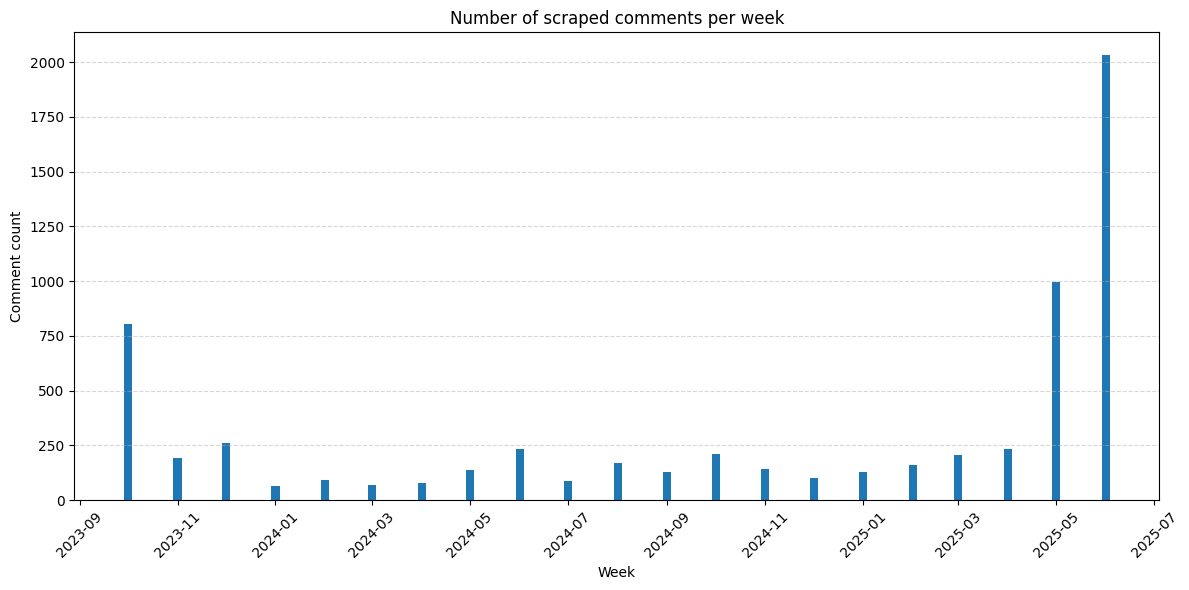

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load data ===
df = pd.read_csv("Text_mining/Database/comments_category1.csv")

# === 2. Parse datetime ===
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df = df.dropna(subset=["published_at"])

# Remove timezone information if present
df["published_at"] = df["published_at"].dt.tz_localize(None)

# === 3. Group by week ===
df["week"] = df["published_at"].dt.to_period("M").apply(lambda r: r.start_time)
weekly_counts = df.groupby("week").size().reset_index(name="comment_count")

# === 4. Plot results ===
plt.figure(figsize=(12, 6))
plt.bar(weekly_counts["week"], weekly_counts["comment_count"], width=5)
plt.title("Number of scraped comments per week")
plt.xlabel("Week")
plt.ylabel("Comment count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

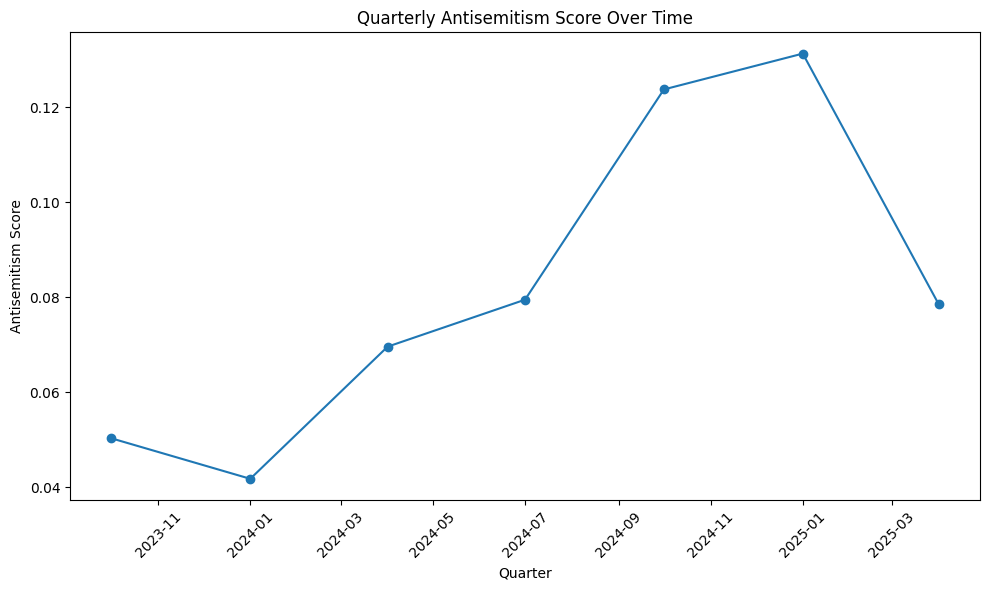

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Path to the results CSV
results_csv_path = 'Text_mining/Database/classification_results.csv'

# Load and preprocess
df = pd.read_csv(results_csv_path, parse_dates=['published_at'])
df['published_at'] = df['published_at'].dt.tz_localize(None)
df['upvotes'] = df['upvotes'].astype(float)
df['label'] = df['label'].astype(int)

# Compute quarter start for each comment
df['quarter_start'] = df['published_at'].dt.to_period('Q').dt.start_time

# Group by quarter_start and compute antisemitism score
quarterly = (
    df.groupby('quarter_start')[['upvotes', 'label']]
      .apply(lambda g: (g['upvotes'] * g['label']).sum() / g['upvotes'].sum()
             if g['upvotes'].sum() > 0 else 0)
      .reset_index(name='antisemitism_score')
)

# Plot the time series
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quarterly['quarter_start'], quarterly['antisemitism_score'], marker='o')
ax.set_xlabel('Quarter')
ax.set_ylabel('Antisemitism Score')
ax.set_title('Quarterly Antisemitism Score Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
